In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
#data source: https://www.kaggle.com/selfishgene/historical-hourly-weather-data?select=weather_description.csv
df = pd.read_csv('data/weather_description.csv')
df = df[['datetime', 'New York']]
df.columns = ['datetime', 'weather_desc']

df['datetime'] = pd.to_datetime(df['datetime'])
df = df[df['datetime'].between('2015-01-01', '2016-01-06', inclusive=True)]

print('Rows before drop nan:', df.shape[0])
df = df.dropna()
print('Rows after:', df.shape[0])

print(df.describe())
df

Rows before drop nan: 8881
Rows after: 8881
                   datetime  weather_desc
count                  8881          8881
unique                 8881            24
top     2015-06-07 20:00:00  sky is clear
freq                      1          2550
first   2015-01-01 00:00:00           NaN
last    2016-01-06 00:00:00           NaN


,datetime,weather_desc
19716,2015-01-01 00:00:00,sky is clear
19717,2015-01-01 01:00:00,sky is clear
19718,2015-01-01 02:00:00,sky is clear
19719,2015-01-01 03:00:00,sky is clear
19720,2015-01-01 04:00:00,sky is clear
...,...,...
28592,2016-01-05 20:00:00,sky is clear
28593,2016-01-05 21:00:00,sky is clear
28594,2016-01-05 22:00:00,sky is clear
28595,2016-01-05 23:00:00,sky is clear


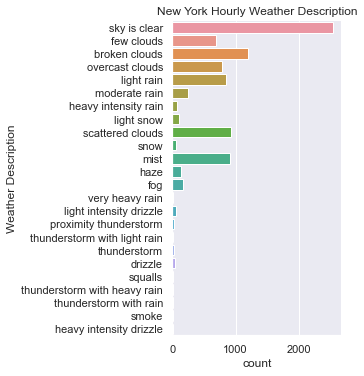

In [3]:
#plot descriptions
sns.set()
sns.catplot(y='weather_desc', kind='count', data=df)
plt.title('New York Hourly Weather Description')
plt.ylabel('Weather Description')
plt.savefig('figs/ny_temp_descriptions.png', dpi=300)

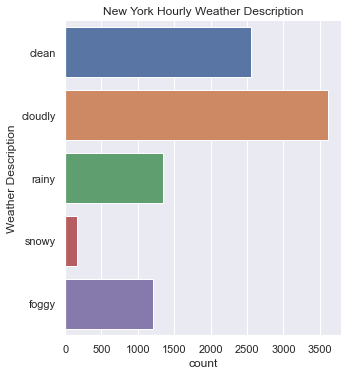

In [4]:
#generalizing weather types
df['weather_desc'].loc[df['weather_desc'].str.contains('clear')]='clean'
df['weather_desc'].loc[df['weather_desc'].str.contains('clouds')]='cloudly'
df['weather_desc'].loc[df['weather_desc'].str.contains('rain|drizzle|thunderstorm|squalls')]='rainy'
df['weather_desc'].loc[df['weather_desc'].str.contains('snow')]='snowy'
df['weather_desc'].loc[df['weather_desc'].str.contains('mist|haze|fog|smoke')]='foggy'

#plotting filtered description
sns.catplot(y='weather_desc', kind='count', data=df)
plt.title('New York Hourly Weather Description')
plt.ylabel('Weather Description')
plt.savefig('figs/ny_temp_descriptions_filtered.png', dpi=300)

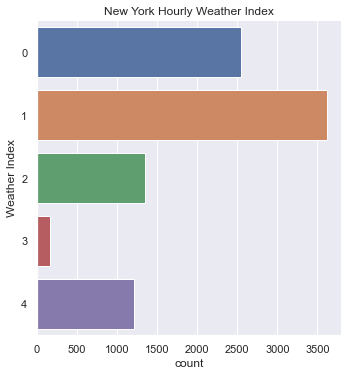

In [5]:
#function to transform each type into an int number
def transform_desc(df, dim):

    conditions = []
    for weather_desc in df['weather_desc'].unique():
        conditions.append(df['weather_desc']==weather_desc)

    weather_desc_index = np.arange(0, dim)
    df['weather_desc_index'] = np.select(conditions, weather_desc_index)

    return(df)

df = transform_desc(df, 5)
#plotting filtered description
sns.catplot(y='weather_desc_index', kind='count', data=df)
plt.title('New York Hourly Weather Index')
plt.ylabel('Weather Index')
plt.savefig('figs/ny_temp_descriptions_filtered_index.png', dpi=300)

In [6]:
def transition_matrix(x, dim):

    P = np.zeros((dim, dim))
    N = len(x)

    for i in range(N-1):

        j = x[i]    #current
        k = x[i+1]  #next

        #probability of state k given state j
        P[k][j] += 1 / N

    return(P)

#create train and test dataframes
df['datetime'] = pd.to_datetime(df['datetime'])
df_train = df[df['datetime'].between('2015-01-01', '2015-10-01')]
df_test = df[df['datetime'].between('2015-10-02', '2016-10-06')]
df_test1 = df[df['datetime'].between('2015-10-25', '2015-10-26')]
df_test2 = df[df['datetime'].between('2016-01-05', '2016-01-06')]

#calculate probs transition matrix
x = list(df_train['weather_desc_index'])
P = transition_matrix(x, 5)
print(P)

[[2.60338776e-01 4.92904013e-02 1.11399359e-02 1.98382420e-03
  6.71448192e-03]
 [5.02060125e-02 2.93911186e-01 1.95330383e-02 2.74683351e-03
  1.17503434e-02]
 [8.08789867e-03 2.28902793e-02 1.05753090e-01 3.05203723e-04
  1.28185564e-02]
 [1.67862048e-03 3.35724096e-03 0.00000000e+00 1.87700290e-02
  1.52601862e-04]
 [9.30871357e-03 8.54570426e-03 1.34289638e-02 1.52601862e-04
  8.69830612e-02]]


In [7]:
#these predictions consider the current state as the actual that ocurred   
def make_predictions(x, n_pred, dim):

    predictions = {
        'prediction': [],
        'max_prob': []
    }

    i = 1

    for state in x:

        if(i<=n_pred):

            x_current = np.zeros(dim)
            x_current[state] = 1

            prediction = np.dot(x_current, P)
            prediction = list(prediction)
            max_prob = prediction.index(max(prediction))

            predictions['prediction'].append(prediction)
            predictions['max_prob'].append(max_prob)

        i += 1

    return(predictions)

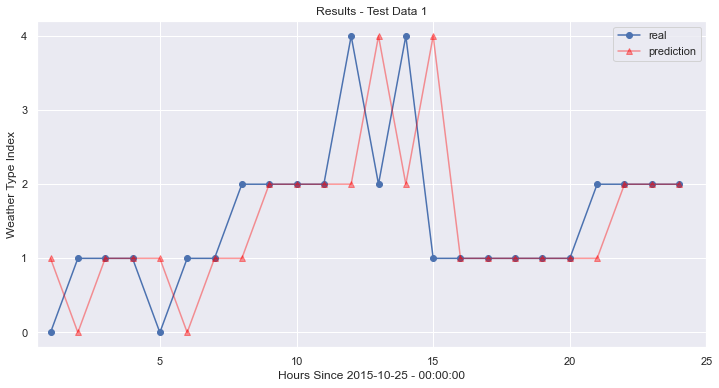

In [8]:
#making predictions test data 1
from matplotlib.ticker import FuncFormatter, MaxNLocator

x = list(df_test1['weather_desc_index'])

predictions = make_predictions(x, df_test1.shape[0]-1, 5)

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(np.arange(1,len(x)), x[1:], '-o', label='real')
ax.plot(np.arange(1,len(x)),predictions['max_prob'], '-^', color='red', alpha=0.4, label='prediction')
ax.legend()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlim([0.5,25])
ax.set_title('Results - Test Data 1')
ax.set_xlabel('Hours Since 2015-10-25 - 00:00:00')
ax.set_ylabel('Weather Type Index')

plt.savefig('figs/result_weather_dftest1.png', dpi=300)

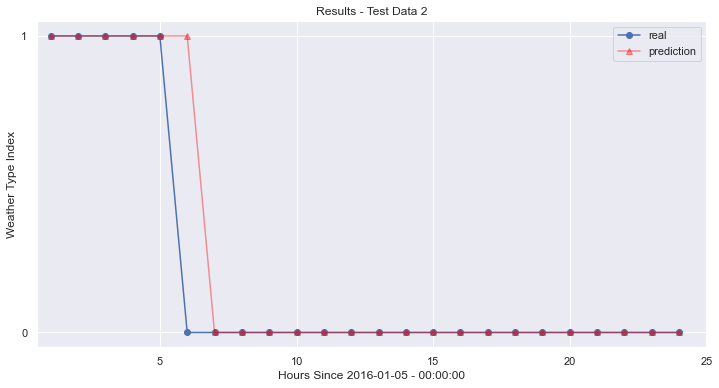

In [9]:
#making predictions on test data 2
x = list(df_test2['weather_desc_index'])
predictions = make_predictions(x, len(x) -1, 5)

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(np.arange(1,len(x)), x[1:], '-o', label='real')
ax.plot(np.arange(1,len(x)), predictions['max_prob'], '-^', color='red', alpha=0.4, label='prediction')
ax.legend()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlim([0.5,25])
ax.set_title('Results - Test Data 2')
ax.set_xlabel('Hours Since 2016-01-05 - 00:00:00')
ax.set_ylabel('Weather Type Index')
plt.savefig('figs/result_weather_dftest2.png', dpi=300)

In [10]:
#calculate stationary dist
def stat_dist(P, dim):

    E = np.ones((dim, dim))
    e = np.ones(dim)
    I = np.identity(dim)

    pi = np.dot(e, np.linalg.inv(I + E - P))

    return(pi)

pi = stat_dist(P, 5)
pi = list(pi)

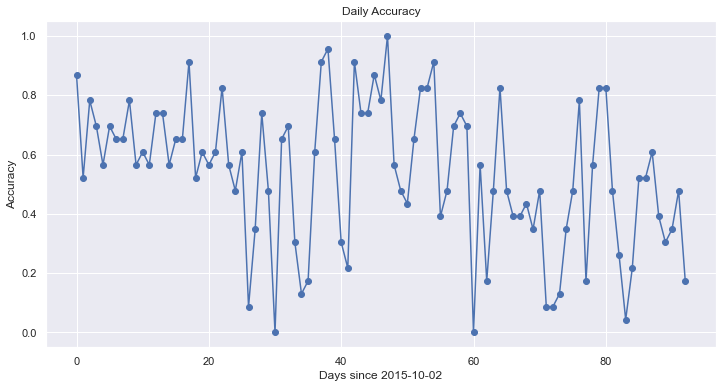

In [11]:
df_test['year'] = df_test['datetime'].dt.year
df_test['month'] = df_test['datetime'].dt.month
df_test['day'] = df_test['datetime'].dt.day
df_test['hour'] = df_test['datetime'].dt.hour

#evaluate accuracy each day over the rest of 2015
df_test = df_test[df_test['year']==2015]

#calculate daily accuracy
accuracy = []
for month in df_test.month.unique():
    for day in df_test.day.unique():

        df_temp = df_test[(df_test['month']==month) & (df_test['day']==day)]
        x = list(df_temp['weather_desc_index'])
        total = len(x) - 1
        predictions = make_predictions(x, total, 5)
        
        x_eval = x[1:]
        right = []
        for i in range(total):
            if (predictions['max_prob'][i] == x_eval[i]):
                right.append(True)
            else:
                right.append(False)

        right = sum(right)
        accuracy.append(right/total)

plt.figure(figsize=(12,6))
plt.title('Daily Accuracy')
plt.plot(accuracy, '-o')
plt.ylabel('Accuracy')
plt.xlabel('Days since 2015-10-02')
plt.savefig('figs/accuracy_markov_chain.png', dpi=300)